## Setup imports

In [1]:
import os
import sys
import itertools
import warnings
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score 

# We need to be able to access the files/directories outside of the `Notebooks` directory.
sys.path.append(os.path.abspath(os.path.join("..")))

from analysis.clustering import affinity_propagation, extract_clusters
from analysis import visualize
from analysis.analysis_utils import Mouse, find_file, extract_epochs, filter_epochs
from analysis.resampling import Resampler
from analysis.graph_analysis_utils import NeuronNetwork

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

# This is to supress future warnings about sklearn's nmi function.
warnings.simplefilter(action='ignore', category=FutureWarning)

##### We load & preprocess the data for a mouse.

In [3]:
s = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_S.csv"), header=None)
c = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_C.csv"), header=None)
behavior = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_Behavior.csv"), header=None)

# Reindex neuron column vectors from 0,1,2,...,n ---> 1,2,3,...,n,n+1
s.columns = [col+1 for col in s.columns]
c.columns = [col+1 for col in c.columns]

behavior_column_names = ['Trial_time',
                         'Recording_time',
                         'X_center',
                         'Y_center',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1_centerpoint',
                         'Open2_centerpoint',
                         'Closed1_centerpoint',
                         'Closed2_centerpoint',
                         'OpenArms_centerpoint',
                         'ClosedArms_centerpoint',
                         'Hardware_command',
                         'Hardware_command_2',
                         'Hardware_command_3',
                         'Hardware_command_4',
                         'Result_1']

# Drop every 3rd row from the behavior dataframe
behavior = Mouse.downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Downsample s (spikes) from 20 fps --> 10 fps: 
# We add a time series column using Timedelta, where the amount of periods is the current
# total amount of frames in the dataframe. 20 fps implies 50 milliseconds per frame, so
# we specify each period to be 50 milliseconds (ms) long.
s = s.assign(Trial_time=pd.timedelta_range(0, periods=len(s.index), freq="50ms"))
c = c.assign(Trial_time=pd.timedelta_range(0, periods=len(c.index), freq="50ms"))

# Finally, we downsample the dataframe into 100 millisecond bins (since 10 fps implies 100 ms per frame). 
# We take the average of the values of the timestamps falling into a bin.
s = s.resample("100ms", on="Trial_time").mean()
c = c.resample("100ms", on="Trial_time").mean()

# Drop the 'Trial_time' time series index, and reset the index by enumerating the frames.
s.reset_index(drop=True, inplace=True)
c.reset_index(drop=True, inplace=True)

# Create a Mouse object to store all of the data for a particular mouse
drd218 = Mouse(cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd218.spikes = drd218.spikes.where(drd218.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (drd218.spikes_and_beh["OpenArms_centerpoint"]) + (drd218.spikes_and_beh["ClosedArms_centerpoint"])
center = 1-center
drd218.spikes_and_beh["Center"] = center

## Place Cell Analysis

In [4]:
from analysis.place_cell_analysis import apply_cantor_pairing

# Extract the X and Y coordinate column vectors and cast all their values to int.
x_coords = drd218.spikes_and_beh["X_center"].astype(int)
y_coords = drd218.spikes_and_beh["Y_center"].astype(int)

# Shift all coordinate values by increasing all of them by the minimum value. This
# is necessary in order to apply the cantor pairing function, since the cantor 
# pairing function is only defined on the natural numbers, i.e., {0, 1, 2, 3, ...}.
x_coords += abs(x_coords.min())
y_coords += abs(y_coords.min())

# Reduce the dimensionality of the coordinates, since sklearn's mutual information 
# function only allows you to compute the NMI between two arrays.
z_coords = apply_cantor_pairing(x_coords.tolist(), y_coords.tolist())
z_coords = pd.Series(data=z_coords)

In [5]:
def nmi_wrapper(dataframe, beh_col_vec):
    """Wrapper to apply sklearn's nmi function to each neuron column 
       vector of dataframe and a given behavior column vector.
    """
    return dataframe.apply(normalized_mutual_info_score, args=(beh_col_vec,))

In [6]:
%time permutation_distributions = Resampler.shuffle(10000, drd218.spikes, nmi_wrapper, z_coords, flip_roll=True)

CPU times: user 27.4 ms, sys: 30.1 ms, total: 57.4 ms
Wall time: 10min 43s


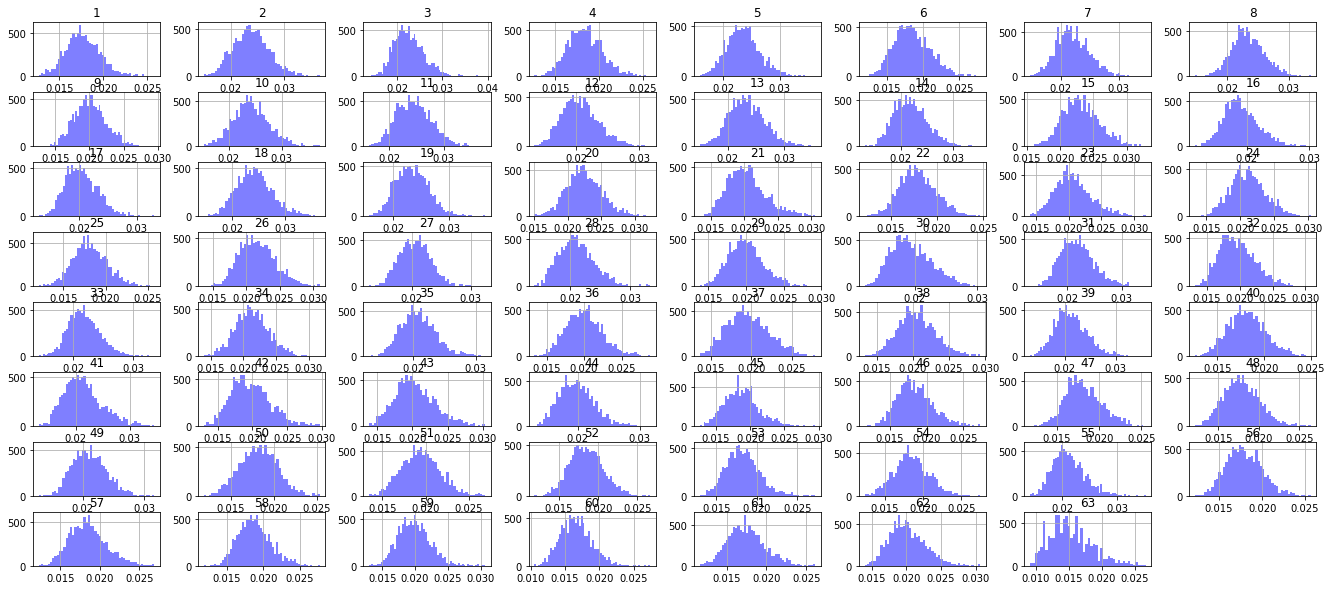

In [7]:
permutation_distributions.hist(alpha=0.5, color="blue", bins="auto", figsize=(23, 10));

In [8]:
original_statistics = nmi_wrapper(drd218.spikes, z_coords)
original_statistics = original_statistics.to_dict()

for neuron, original_stat in original_statistics.items():
    p_value = Resampler.p_value(original_stat, permutation_distributions[neuron])
    if p_value < 0.05:
        print("neuron {}: p<{}".format(neuron, p_value))

neuron 1: p<0.0004
neuron 4: p<0.0
neuron 8: p<0.0
neuron 18: p<0.0
neuron 20: p<0.0
neuron 22: p<0.008
neuron 23: p<0.0296
neuron 24: p<0.0344
neuron 25: p<0.0
neuron 27: p<0.0056
neuron 31: p<0.0204
neuron 33: p<0.0328
neuron 34: p<0.0236
neuron 35: p<0.0268
neuron 38: p<0.0188
neuron 40: p<0.0
neuron 46: p<0.0028
neuron 49: p<0.0
neuron 50: p<0.0068000000000000005
neuron 52: p<0.0036000000000000003
neuron 56: p<0.0432
neuron 57: p<0.0088
neuron 58: p<0.002
neuron 59: p<0.046


In [9]:
for neuron, original_stat in original_statistics.items():
    result = Resampler.two_tailed_test(original_stat, permutation_distributions[neuron])
    print("neuron {}: result={}".format(neuron, result))

neuron 1: result=1
neuron 2: result=0
neuron 3: result=0
neuron 4: result=1
neuron 5: result=0
neuron 6: result=0
neuron 7: result=0
neuron 8: result=1
neuron 9: result=0
neuron 10: result=0
neuron 11: result=0
neuron 12: result=0
neuron 13: result=0
neuron 14: result=0
neuron 15: result=0
neuron 16: result=0
neuron 17: result=0
neuron 18: result=1
neuron 19: result=0
neuron 20: result=1
neuron 21: result=0
neuron 22: result=1
neuron 23: result=1
neuron 24: result=1
neuron 25: result=1
neuron 26: result=0
neuron 27: result=1
neuron 28: result=0
neuron 29: result=0
neuron 30: result=0
neuron 31: result=1
neuron 32: result=0
neuron 33: result=1
neuron 34: result=1
neuron 35: result=1
neuron 36: result=0
neuron 37: result=0
neuron 38: result=1
neuron 39: result=0
neuron 40: result=1
neuron 41: result=0
neuron 42: result=0
neuron 43: result=0
neuron 44: result=0
neuron 45: result=0
neuron 46: result=1
neuron 47: result=0
neuron 48: result=0
neuron 49: result=1
neuron 50: result=1
neuron 51

## Heatmaps

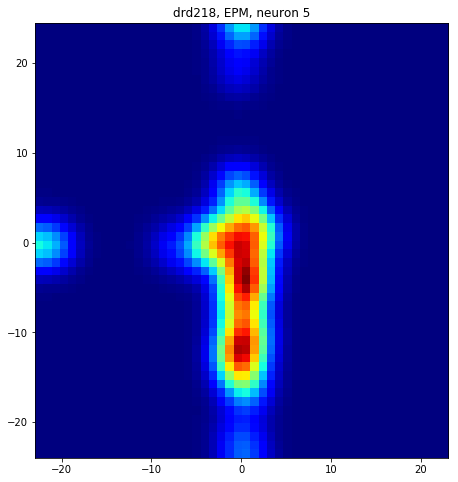

In [10]:
neuron = 5
x = drd218.spikes_and_beh["X_center"]
y = drd218.spikes_and_beh["Y_center"]

# We need to create a vector of boolean values for when the (provided) neuron 
# fired and didn't fire. This is passed to the plot_heatmap function in order 
# to only create a heatmap based on where the neuron fired.
weights = (drd218.spikes_and_beh[neuron] != 0).astype(int)

visualize.plot_heatmap(x, y, sigma=2, title="drd218, EPM, neuron {}".format(neuron), figsize=(8, 8), weights=weights, savefig=False);

## Cell Selectivity

##### Use the `shuffle` function in order to create a permutation distribution, for each neuron, of the difference of means.

In [11]:
%time permutation_distributions_dataframe = Resampler.shuffle(10000, drd218.spikes, Resampler.diff_of_mean_rate, drd218.spikes_and_beh["OpenArms_centerpoint"], drd218.spikes_and_beh["ClosedArms_centerpoint"])

CPU times: user 17.5 ms, sys: 28.5 ms, total: 46 ms
Wall time: 15.1 s


##### Plot the permutation distributions

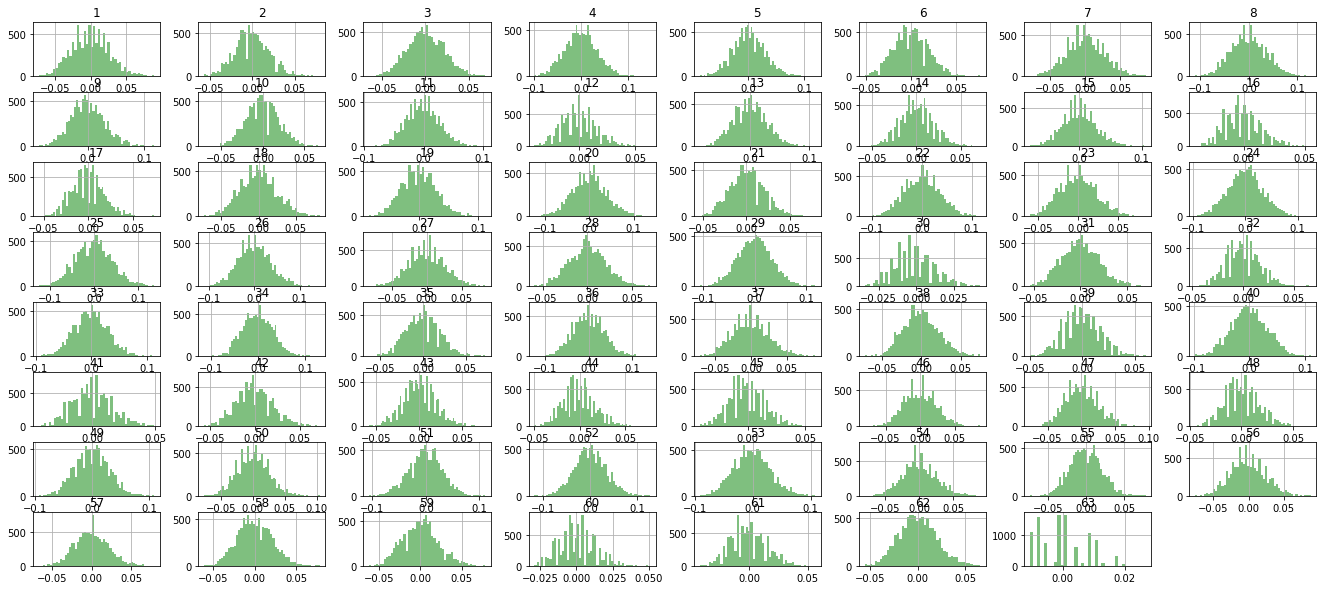

In [12]:
permutation_distributions_dataframe.hist(alpha=0.5, color="green", bins="auto", figsize=(23, 10));

##### Classify cells by the behavior for which they are selective.

In [13]:
original_diff_of_means = dict(zip(drd218.spikes.columns, Resampler.diff_of_mean_rate(drd218.spikes, drd218.spikes_and_beh["OpenArms_centerpoint"], drd218.spikes_and_beh["ClosedArms_centerpoint"])))

p_values = {}
for neuron, original_stat in original_diff_of_means.items():
    p_value = Resampler.p_value(original_diff_of_means[neuron], permutation_distributions_dataframe[neuron])
    p_values[neuron] = p_value
    print("neuron {}: p={}".format(neuron, p_value))

neuron 1: p=0.756
neuron 2: p=0.0216
neuron 3: p=0.0
neuron 4: p=0.038400000000000004
neuron 5: p=0.18280000000000002
neuron 6: p=0.0016
neuron 7: p=0.5148
neuron 8: p=0.28040000000000004
neuron 9: p=0.2884
neuron 10: p=0.0376
neuron 11: p=0.0
neuron 12: p=0.008400000000000001
neuron 13: p=0.0
neuron 14: p=0.0108
neuron 15: p=0.134
neuron 16: p=0.39280000000000004
neuron 17: p=0.3276
neuron 18: p=0.0
neuron 19: p=0.0
neuron 20: p=0.054400000000000004
neuron 21: p=0.9536
neuron 22: p=0.0
neuron 23: p=0.0
neuron 24: p=0.002
neuron 25: p=0.0032
neuron 26: p=0.0004
neuron 27: p=0.0
neuron 28: p=0.0704
neuron 29: p=0.0
neuron 30: p=0.0
neuron 31: p=0.38720000000000004
neuron 32: p=0.0584
neuron 33: p=0.1804
neuron 34: p=0.0
neuron 35: p=0.0
neuron 36: p=0.0
neuron 37: p=0.0
neuron 38: p=0.5044000000000001
neuron 39: p=0.44160000000000005
neuron 40: p=0.0036000000000000003
neuron 41: p=0.0
neuron 42: p=0.67
neuron 43: p=0.1516
neuron 44: p=0.08
neuron 45: p=0.0032
neuron 46: p=0.0028
neuron 

In [14]:
classified_cells = {}

for neuron, p_value in p_values.items():
    if p_value < 0.05 and original_diff_of_means[neuron] > 0:
        classified_cells[neuron] = "OpenArms_centerpoint"
    elif p_value < 0.05 and original_diff_of_means[neuron] < 0:
        classified_cells[neuron] = "ClosedArms_centerpoint"
    elif p_value >= 0.05:
        classified_cells[neuron] = "Not-selective"
        
classified_cells

{1: 'Not-selective',
 2: 'OpenArms_centerpoint',
 3: 'OpenArms_centerpoint',
 4: 'OpenArms_centerpoint',
 5: 'Not-selective',
 6: 'OpenArms_centerpoint',
 7: 'Not-selective',
 8: 'Not-selective',
 9: 'Not-selective',
 10: 'OpenArms_centerpoint',
 11: 'OpenArms_centerpoint',
 12: 'ClosedArms_centerpoint',
 13: 'OpenArms_centerpoint',
 14: 'OpenArms_centerpoint',
 15: 'Not-selective',
 16: 'Not-selective',
 17: 'Not-selective',
 18: 'OpenArms_centerpoint',
 19: 'OpenArms_centerpoint',
 20: 'Not-selective',
 21: 'Not-selective',
 22: 'ClosedArms_centerpoint',
 23: 'OpenArms_centerpoint',
 24: 'OpenArms_centerpoint',
 25: 'OpenArms_centerpoint',
 26: 'OpenArms_centerpoint',
 27: 'OpenArms_centerpoint',
 28: 'Not-selective',
 29: 'OpenArms_centerpoint',
 30: 'OpenArms_centerpoint',
 31: 'Not-selective',
 32: 'Not-selective',
 33: 'Not-selective',
 34: 'OpenArms_centerpoint',
 35: 'OpenArms_centerpoint',
 36: 'OpenArms_centerpoint',
 37: 'OpenArms_centerpoint',
 38: 'Not-selective',
 39: 'No

##### Plot a pie chart in order to visualize the proportions of cells that are selective for behaviors of interest.

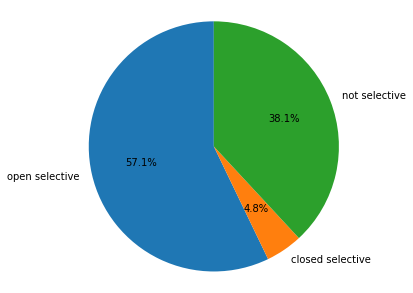

In [15]:
open_selective = 0
closed_selective = 0
not_seletive = 0

for cell, classification in classified_cells.items():
    if classification == "OpenArms_centerpoint":
        open_selective += 1
    elif classification == "ClosedArms_centerpoint":
        closed_selective += 1
    elif classification == "Not-selective":
        not_seletive += 1
        
# Plot a pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = [open_selective, closed_selective, not_seletive]
visualize.pie_chart(sizes, "open selective", "closed selective", "not selective")

## Clustering

##### The functions below are stand-alone functions meant to help with clustering analysis.

In [16]:
def compute_nmi(dataframe):
    connections = {}
    matrix = nmi_matrix(dataframe)
    
    for combination in itertools.combinations(matrix.columns, 2):
        nmi = matrix[combination[0]][combination[1]]
        connections[combination] = nmi
    
    return connections

def compute_corrcoef(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        if dataframe[neuron_pair[0]].std() == 0 or dataframe[neuron_pair[1]].std() == 0:
            continue

        corrcoef = np.corrcoef(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)[0][1]
        if corrcoef >= 0:
            connections[neuron_pair] = corrcoef
        
    return connections

def nmi_matrix(dataframe):
    rows = []
    
    for col in dataframe:
        row = dataframe.apply(normalized_mutual_info_score, args=(dataframe[col],))
        rows.append(row)

    return pd.DataFrame(rows, index=dataframe.columns) 

def plot_traces(clusters, mouse, all_beh_intervals=None, **kwargs):
    figsize = kwargs.get("figsize", (15, 6))
    hspace = kwargs.get("hspace", 0.0)
    title = kwargs.get("title", "Title Goes Here")
    total_subplots = 0
    
    for cluster in clusters:
        if len(clusters[cluster]) > 1:
            total_subplots += len(clusters[cluster])
            
    cmap = get_cmap(max(clusters.keys())+1, name="Dark2")
    fig, ax = plt.subplots(total_subplots, 1, figsize=figsize)
    
    ax_index = 0
    dataframe = mouse.cell_transients
    bg_colors = ["blue", "orange", "red", "green"]

    for cluster in clusters:
        if len(clusters[cluster]) > 1:
            for index in range(0, len(clusters[cluster])):
                ax[ax_index].plot(dataframe.index, dataframe[clusters[cluster][index]], c=cmap(cluster), lw=1)
                
                if all_beh_intervals:
                    for i, behavior_intervals in enumerate(all_beh_intervals):
                        for interval in behavior_intervals:
                            ax[ax_index].axvspan(interval[0], interval[-1], alpha=0.1, color=bg_colors[i])
                            ax[ax_index].axis("off")
                        
                ax_index += 1
            
    plt.subplots_adjust(wspace=0, hspace=hspace)
    
    if kwargs.get("save", False):
        plt.savefig(title+".pdf", dpi=600)
        
    plt.show();
    
def get_cmap(n, name="tab20"):
    """ Returns a function that maps each index in 0,1,...,n-1 
        to a distinct RGB color; the keyword argument name must 
        be a standard mpl colormap name.
    """
    return plt.cm.get_cmap(name, n)

def get_neuron_positions(neuron_network, coordinates_df):
    """Create a dictionary of all the neuron cartestian coordinates
    """
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

##### We load & preprocess all the data for another mouse.

In [17]:
c = pd.read_csv(find_file("Hen_Lab/Mice", "Drd87_EPM_C_thresh.csv"), header=None)
s = pd.read_csv(find_file("Hen_Lab/Mice", "Drd87_EPM_S_thresh.csv"), header=None)
behavior = pd.read_csv(find_file("Hen_Lab/Mice", "DRD87_EPM_NEW_BEH.csv"), header=None)

# Reindex neuron column vectors from 0,1,2,...,n ---> 1,2,3,...,n,n+1
s.columns = [col+1 for col in s.columns]
c.columns = [col+1 for col in c.columns]

behavior_column_names = ['Trial_time',
                         'Recording_time',
                         'X_center',
                         'Y_center',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1_centerpoint',
                         'Open2_centerpoint',
                         'Closed1_centerpoint',
                         'Closed2_centerpoint',
                         'OpenArms_centerpoint',
                         'ClosedArms_centerpoint',
                         'Hardware_command',
                         'Hardware_command_2',
                         'Hardware_command_3',
                         'Hardware_command_4',
                         'Result_1',
                         "Head_Dips"]

# Drop every 3rd row from the behavior dataframe 
behavior = Mouse.downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Create a Mouse object to store all of the data for a particular mouse
drd87 = Mouse(cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd87.spikes = drd87.spikes.where(drd87.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (drd87.spikes_and_beh["OpenArms_centerpoint"]) + (drd87.spikes_and_beh["ClosedArms_centerpoint"])
center = 1-center
drd87.spikes_and_beh["Center"] = center

##### We read in the cartesian coordinates of drd87's neurons, as imaged.

In [18]:
coordinates = pd.read_csv(find_file("Hen_Lab/Mice", "EPM_NO_OFT_POPP_centroids.csv"), header=None)
coordinates.columns = ['x', 'y']

# Reset the index so that it starts from 1, since it is more natural to enumerate neurons as 1, 2, ..., n
coordinates.index = pd.RangeIndex(1, len(coordinates.index)+1)

##### We find all possible clusters of neurons for drd87 in EPM during the overall session. 

In [19]:
# connections = compute_corrcoef(drd87.auc_df)
connections = compute_nmi(drd87.spikes)
drd87_graph = NeuronNetwork(drd87.spikes.columns, connections)
pos = get_neuron_positions(drd87_graph, coordinates)
  
# X = drd87.auc_df.corr().where(drd87.auc_df.corr() >= 0, 0)
X = nmi_matrix(drd87.spikes)
clusters = affinity_propagation(X)

##### We plot the imaged neurons by their actual positions, and we color code each neuron by its respective cluster.

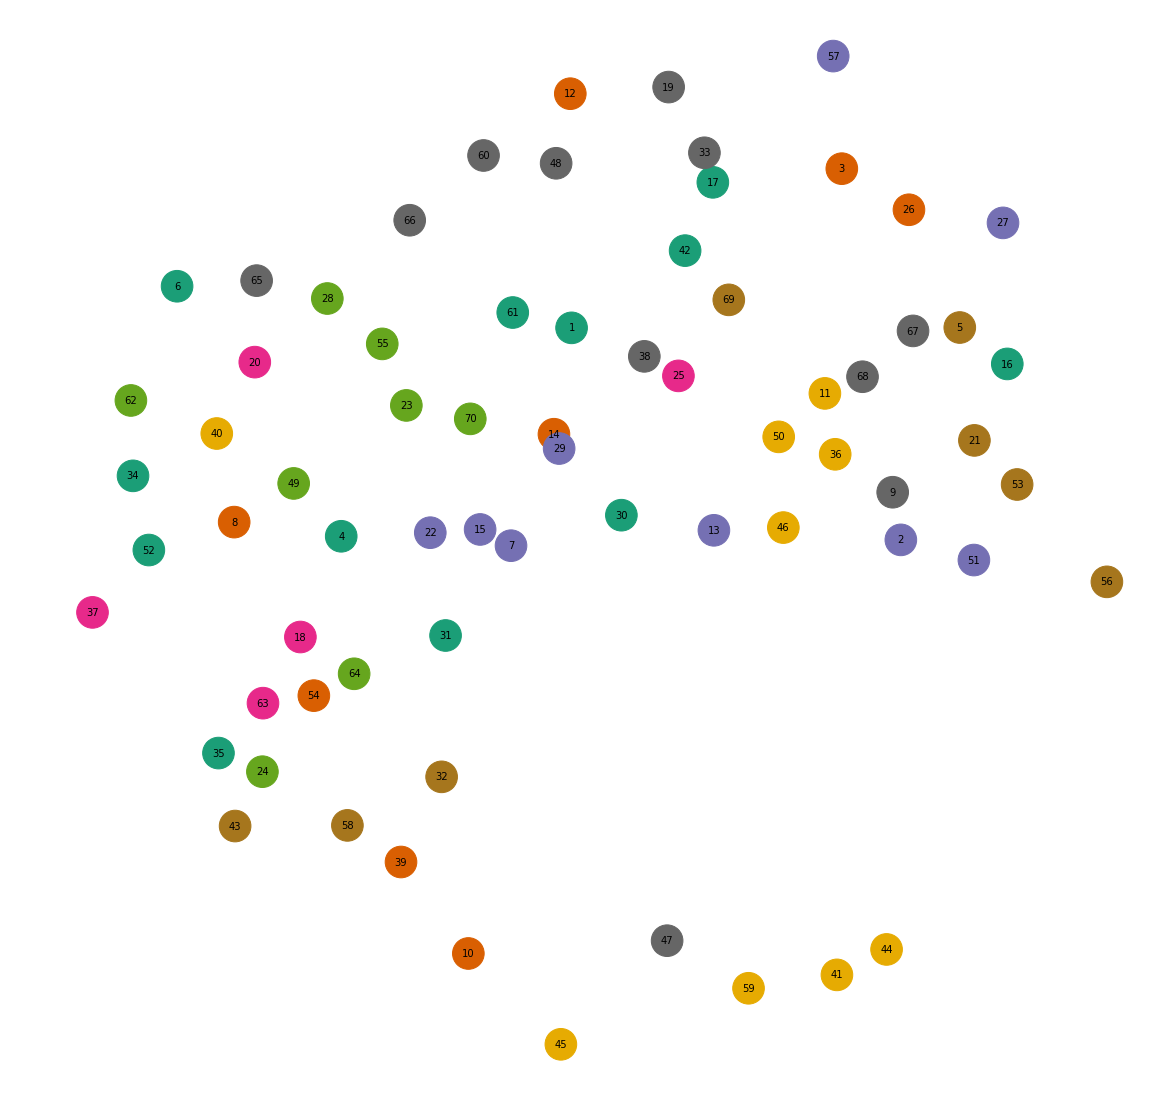

In [20]:
node_colors = [clusters[key] for key in sorted(clusters.keys())]
drd87_graph.plot(pos=pos, node_colors=node_colors, figsize=(20,20), node_size=1000, draw_edges=False, save=False, file_name="drd87_overall_nmi.png")

##### We plot the continuous time series plots, for each neuron that was assigned to a cluster with $2$ or more neurons. Each time series plot is color coded its respective cluster. 

In [21]:
all_behavior_intervals = []
for behavior in ["OpenArms_centerpoint", "ClosedArms_centerpoint", "Center", "Head_Dips"]:
    epochs = extract_epochs(drd87, behavior)
    behavior_intervals = filter_epochs(epochs[1], framerate=1, seconds=1)
    all_behavior_intervals.append(behavior_intervals)

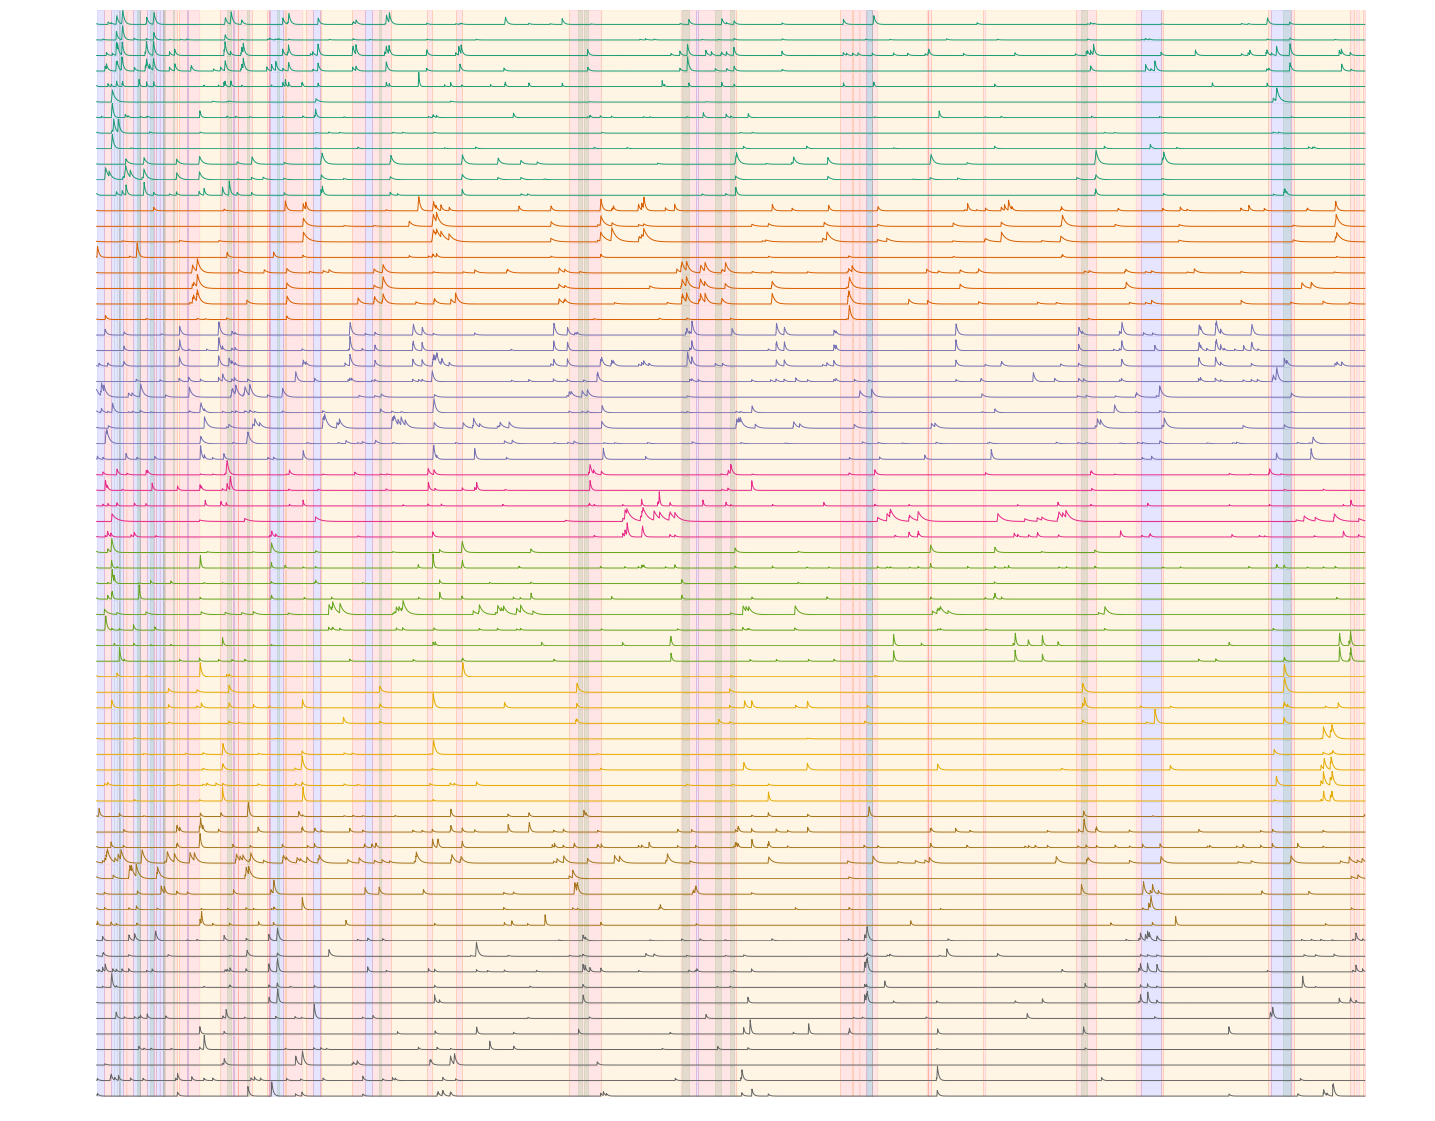

In [22]:
clusters = extract_clusters(clusters)
plot_traces(clusters, drd87, all_beh_intervals=all_behavior_intervals, figsize=(25, 20), hspace=0.0, save=True, title="drd87 cluster traces")

## Graph Theoretical Analysis

##### We begin by computing the mutual information between all possible pairs of neurons. We provide the `NeuronNetwork` object with the names of the neurons (nodes), and the functional connectivity (mutual information) between all pairs of neurons.

In [23]:
connections = compute_nmi(drd87.spikes)
drd87_graph = NeuronNetwork(drd87.spikes.columns, connections)

##### Compute the mean [betweeness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) of drd87's neuron network.

In [24]:
drd87_graph.mean_betw_cent()

0.03677383997077092

##### Compute the average clustering coefficient for drd87's network of neurons.

In [25]:
nx.average_clustering(drd87_graph.network, weight="weight")

0.008237659349134513

##### Compute the average clustering coefficient for each extracted cluster.

In [26]:
for _, cluster in clusters.items():
    avg_cluster_coeff = np.mean(list(nx.clustering(drd87_graph.network, weight="weight", nodes=cluster).values()))
    print("avg clustering coefficient of {} = {}".format(cluster, avg_cluster_coeff))    

avg clustering coefficient of [1, 17, 34, 35, 61] = 0.007893634603678831
avg clustering coefficient of [4, 30, 31, 52] = 0.010474403391894767
avg clustering coefficient of [6, 16, 42] = 0.00880190067820495
avg clustering coefficient of [8, 10, 14, 39] = 0.009042416857373383
avg clustering coefficient of [3, 12, 26, 54] = 0.006520072093444938
avg clustering coefficient of [2, 13, 29, 51] = 0.008172447995448483
avg clustering coefficient of [7, 15, 22, 27, 57] = 0.007196653902851518
avg clustering coefficient of [18, 25, 63] = 0.008252166692212884
avg clustering coefficient of [20, 37] = 0.007144472091396466
avg clustering coefficient of [23, 49, 55, 70] = 0.012737888455674968
avg clustering coefficient of [24, 64] = 0.0060768764159548445
avg clustering coefficient of [28, 62] = 0.007259285760885465
avg clustering coefficient of [40, 41, 44, 59] = 0.009336090158325098
avg clustering coefficient of [11, 36, 45, 46, 50] = 0.009166080909463524
avg clustering coefficient of [21, 53, 56] = 0.

##### Compute the mean shortest path length of drd87's network of neurons. Recall: "random and complex networks have short mean path lengths (high global efficiency of parallel information transfer)" (Bullmore & Sporns 2009)

In [27]:
drd87_graph.avg_shortest_path_len()

0.0006139240057489981

##### Compute the small-worldness of drd87's network of neurons. Recall: "a convenient single-number summary of small-worldness is thus the ratio of the clustering coefficient to the path length after both metrics have been standardized by comparing their values to those in equivalent random networks" (Bullmore & Sporns 2009)

In [28]:
drd87_graph.small_worldness()

13.418044044530271

##### We the compute the degree assortativity of the neuron network.

In [29]:
nx.degree_pearson_correlation_coefficient(drd87_graph.network, weight="weight")

-0.014492753623188404